In [1]:
%%time
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

CPU times: user 19 µs, sys: 11 µs, total: 30 µs
Wall time: 31.5 µs


In [2]:
%%time
from WGE.utils import generate_output
from WGE.utils import save_scores_to_csv
from WGE.utils import save_to_csv

CPU times: user 4.25 ms, sys: 84 µs, total: 4.33 ms
Wall time: 35.2 ms


In [3]:
%%time
#################################
#调用 generate_output 函数
#################################
import numpy as np
import matplotlib.pyplot as plt

def Plot_Total(output:bool, random_disturb:bool, measurement:bool, MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0, 0.86, 0.05)

    # Create a figure and axes
    fig, ax = plt.subplots()

    labels = ['μ=0.01', 'μ=0.1', 'μ=0.2', 'μ=0.3', 'μ=0.4', 'μ=0.5']
    colors = ['red', 'orange', 'green', 'blue', 'indigo', 'violet']

    for i in range(len(labels)):
        ax.plot(x_values, [MEAN[j][i] for j in range(len(MEAN))], label=labels[i], color=colors[i])
        ax.fill_between(x_values, np.subtract([MEAN[j][i] for j in range(len(MEAN))], [STD[j][i] for j in range(len(STD))]),
                         np.add([MEAN[j][i] for j in range(len(MEAN))], [STD[j][i] for j in range(len(STD))]), alpha=0.2, color=colors[i])

    # Set labels and title
    ax.set_xlabel('Percentage of Nodes Removed')

    if measurement:
        ax.set_ylabel('NMI')
    else:
        ax.set_ylabel('ECSim')
    #ax.set_title('Total Plot')

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = 0 #y_min - y_offset - 0.01
    y_upper = 1.02
    ax.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.05
    y_ticks = np.arange(np.ceil(y_lower * 10) / 10, y_upper + 0.5*y_tick_step, y_tick_step)
    # Add horizontal reference lines
    for y in y_ticks:
        ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        
    ax.set_yticks(y_ticks)

    # Add a legend
    ax.legend()

    # Adjust the figure size
    fig.set_size_inches(10, 6)
    fig.suptitle('Total Plots', y=0.95)

    if output:
        filename = filename+"_TOTAL"

        file_path = generate_output(random_disturb, filename+".png")
        plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 1.82 s, sys: 7.08 s, total: 8.91 s
Wall time: 2.81 s


In [4]:
%%time
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from WGE.lle import lles
from WGE.DeepWalk import DeepWalk
from karateclub import MNMF
from ge import LINE
from node2vec import Node2Vec

from clusim.clustering import Clustering

def perform_hope_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    hope_model = HOPE(d=embedding_dimension, beta=0.01)
    embd = hope_model.learn_embedding(graph=graph_copy, is_weighted=False, no_python=True)
    return embd

def perform_laplacian_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    lap_model = LaplacianEigenmaps(d=embedding_dimension)
    embd = lap_model.learn_embedding(graph=graph_copy, is_weighted=False, no_python=True)
    return embd

def perform_lle_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    embd = lles(graph_copy, embedding_dimension)
    return embd

def perform_deepwalk_embedding(graph, nodes_to_remove, embedding_dimension, _, __, wk=32):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    model = DeepWalk(dimensions=embedding_dimension, walk_length=16, window_size=10, walk_number=10, workers=wk)
    model.fit(graph_copy)
    embd = model.get_embedding()
    return embd

def perform_mnmf_embedding(graph, nodes_to_remove, embedding_dimension, number_of_intrinsic_clusters, _, __):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    H = nx.relabel.convert_node_labels_to_integers(graph_copy)
    MNMF_model = MNMF(dimensions=embedding_dimension, clusters=number_of_intrinsic_clusters, 
                      lambd=0.2, alpha=0.05, beta=0.05, iterations=100, lower_control=1e-15, eta=5.0, seed=42)
    MNMF_model.fit(H)
    embd = MNMF_model.get_embedding()
    return embd


def perform_line_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    model = LINE(graph_copy, embedding_size=embedding_dimension, order='first')
    model.train(batch_size=8192, epochs=50, verbose=0)
    LINE_embd = model.get_embeddings()
    embd = list(LINE_embd.values())
    return embd

def perform_node2vec_embedding(graph, nodes_to_remove, embedding_dimension,_, idx, wk=32):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    node2vec_model = Node2Vec(graph_copy, dimensions=embedding_dimension, walk_length=16, num_walks=10, workers=wk, quiet=True)
    node2vec_fit = node2vec_model.fit(window=10, min_count=1, batch_words=80000)
    nodes_range = np.array(range(graph.number_of_nodes()))
    nodes = [str(x) for x in nodes_range[idx]]
    embd = np.array([node2vec_fit.wv[node] for node in nodes])
    return embd

from WGE.eval_embd import eval_embd as EE
def calculate_score(embd, intrinsic_membership, number_of_intrinsic_clusters):
    intrin_list = intrinsic_membership
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    score = EE(number_of_intrinsic_clusters, intrin_list, intrin_Clus, embd)
    return score

def Comprehensive_Processing(output:bool, random_disturb:bool, method: int, num_cpus:int, 
                             graph, embedding_dimension, intrinsic_membership, remove_procedure, remove_procedure_index_form):
    labels = ["1HOPE", "2LAP", "3LLE", "4DeepWalk", "5MNMF", "6LINE", "7Node2Vec"]
    print(labels[method-1])
    
    
    embedding_methods = {
        1: (perform_hope_embedding, "HOPE"),
        2: (perform_laplacian_embedding, "LAP"),
        3: (perform_lle_embedding, "LLE"),
        4: (perform_deepwalk_embedding, "DeepWalk"),
        5: (perform_mnmf_embedding, "MNMF"),
        6: (perform_line_embedding, "LINE"),
        7: (perform_node2vec_embedding, "Node2Vec")
    }

    embedding_func, method_label = embedding_methods[method]

    number_of_intrinsic_clusters = len(np.unique(intrinsic_membership))
    idxx = np.ones(graph.number_of_nodes(), dtype=bool)
    embd = embedding_func(graph, [], embedding_dimension, number_of_intrinsic_clusters, idxx, num_cpus)
    score_0 = calculate_score(embd, intrinsic_membership[idxx], number_of_intrinsic_clusters)
    MEAN = [np.array(score_0)]
    
    STD = [np.array([0,0,0,0])]
    
    for rp, idx in zip(remove_procedure, remove_procedure_index_form):
        scores = []
        for nodes_to_remove, idxx in zip(rp, idx):
            number_of_intrinsic_clusters = len(np.unique(intrinsic_membership[idxx]))
            embd = embedding_func(graph, nodes_to_remove, embedding_dimension, number_of_intrinsic_clusters, idxx, num_cpus)
            score = calculate_score(embd, intrinsic_membership[idxx], number_of_intrinsic_clusters)
            scores.append(score)

        array = np.array(scores)
        mean = np.mean(array, axis=0)
        std = np.std(array, axis=0)
        MEAN.append(mean)
        STD.append(std)
        if output:
            save_scores_to_csv(random_disturb, scores, labels[method-1] + "_SCORES")
            save_to_csv(random_disturb, MEAN, labels[method-1] + "_MEAN")
            save_to_csv(random_disturb, STD, labels[method-1] + "_STD")
    return MEAN, STD

CPU times: user 4.67 s, sys: 8.99 s, total: 13.7 s
Wall time: 58 s


The code snippet you provided references several functions that are not defined within the provided code snippet. Here are the functions that are not defined:

1. `generate_output`: This function is used to generate the output file path for saving CSV files and plots. Its implementation is not included in the provided code snippet.

2. `save_scores_to_csv`: This function is referenced within the `Comprehensive_Processing` function and is used to save scores to a CSV file. Its implementation is not included in the provided code snippet.

3. `save_to_csv`: This function is referenced within the `Comprehensive_Processing` function and is used to save data to a CSV file. Its implementation is not included in the provided code snippet.

4. `Plot_Combine`: This function is referenced within the `Comprehensive_Processing` function and is used to generate a combined plot. Its implementation is not included in the provided code snippet.

5. `Plot_Total`: This function is referenced within the `Comprehensive_Processing` function and is used to generate a total plot. Its implementation is not included in the provided code snippet.

6. `EE`: This function is referenced within the `calculate_score` function and is used to calculate an evaluation metric. Its implementation is not included in the provided code snippet.

7. `Clustering`: This class is referenced within the `calculate_score` function and is used to create a clustering object. Its implementation is not included in the provided code snippet.

Without the implementation of these missing functions, the provided code snippet will not run successfully. You will need to define or provide the implementations of these functions in order to use the code properly.

以上这段代码是自洽的

In [5]:
### 读取存储的图的相关信息
### 从文件中读入内容并转化成 边列表
import networkx as nx

MU = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
graphs = {}
membership={}
between={}

for mu in MU:
    with open(f'graph_1000_{mu}.edgelist', 'r') as file:
        lines = file.readlines()

    ### Process the lines and create a list of number pairs
    edge_list = []
    for line in lines:
        pair = tuple(map(int, line.strip().split()))
        edge_list.append(pair)

    ### 新建一个图 
    G = nx.Graph()
    ### 向图添加点和边
    sorted_nodes=sorted(set(range(1000)))
    G.add_nodes_from(sorted_nodes)
    G.add_edges_from(edge_list)
    graphs[mu]=G
    ### Load Community Info
    import numpy as np
    membership_list = f'graph_1000_{mu}.membership'
    membership[mu] = np.loadtxt(membership_list, dtype=int)
    
    ### Load Betweeness
    btwn_file = f'graph_1000_{mu}.between'
    between[mu] = np.loadtxt(btwn_file)
    
import json

remove_procedure={}
for mu in MU:
    with open(f'graph_1000_{mu}.rmvproc', 'r') as file:
        remove_procedure[mu] = json.load(file)
        
#需要调用 remove_procedure_index
from WGE.remove_procedure import remove_procedure_index
index={}
for mu in MU:
    index[mu] = remove_procedure_index(remove_procedure=remove_procedure[mu], num_nodes=graphs[mu].number_of_nodes())

In [6]:
%%time
#from auxpack.eval_embd import eval_embd as EE
#from clusim.clustering import Clustering

D=10

output_flag=False
random_disturb=True

num_cpus_n2v = 1

import multiprocessing
num_cpus = multiprocessing.cpu_count()
print(num_cpus)

128
CPU times: user 18 µs, sys: 42 µs, total: 60 µs
Wall time: 65.3 µs


下面的各个 Cell 调用了 Comprehensive_Processing 函数

In [7]:
MEAN = {}
STD = {}
for mu in MU:    
    MEAN[mu], STD[mu] = Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=3, num_cpus=num_cpus, 
                                                 graph = graphs[mu], embedding_dimension=D, intrinsic_membership=membership[mu], 
                                                 remove_procedure=remove_procedure[mu], remove_procedure_index_form=index[mu])

3LLE
3LLE
3LLE
3LLE
3LLE
3LLE


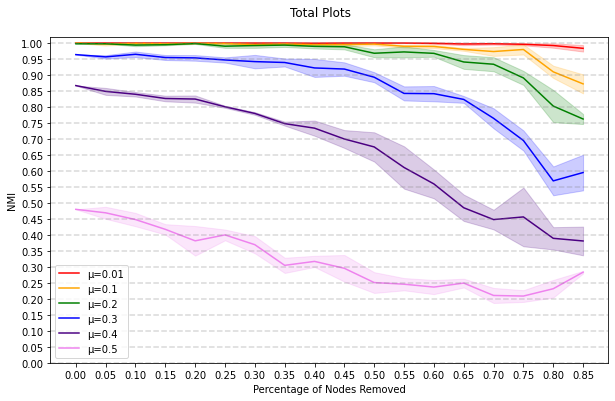

In [9]:
MM=[]  

for i in range(18):
    mm=[]
    for mean in MEAN.values():
        mm.append(mean[i][0])
    MM.append(mm)
    
SS=[]  
for i in range(18):
    ss=[]
    for std in STD.values():
        ss.append(std[i][0])
    SS.append(ss)
    
Plot_Total(output=output_flag, random_disturb=random_disturb, measurement=True, MEAN=MM, STD=SS, filename="TEST")